In [1]:
import pandas as pd
import numpy as np
import seaborn
from nltk.corpus import stopwords

In [2]:
data_read=pd.read_csv("alldata.csv",delimiter=",",header=0)

In [3]:
data_read.tail()

,position,company,description,reviews,location
6959,Data Developer / Machine Learning Analyst,NetApp,Are you data-driven? We at NetApp believe in t...,574.0,"Sunnyvale, CA"
6960,Scientist I,"Pharmacyclics, an Abbvie Company",Pharmacyclics is committed to the development ...,26.0,"Sunnyvale, CA"
6961,Intern Scientist,Oath Inc,"Oath, a subsidiary of Verizon, is a values-led...",5.0,"Sunnyvale, CA"
6962,Senior Data & Applied Scientist,Microsoft,We are the Bing Core Relevance team responsibl...,4618.0,"Sunnyvale, CA"
6963,"Principal Data Scientist, Deep Learning",Comcast,Comcast’s Technology &amp; Product organizatio...,11610.0,"Sunnyvale, CA 94089"


## Nettoyage des différents types d'offre:
Comme on veut avoir des labels avec tout simplement 3 classes{data scientist,data engineer, data analyst}, on va d'abord construire à partir des mots clés dont on dispose ces classes. 

## Construction des listes de mots clés filtres:
En se basant sur des mots clés liés reperer dans les labels, nous les avons arbitraiment
assignés dans une des trois classes.

## Preprocessing:

On va d'abord enlever ponctuation:

In [4]:
data_read["position"]= data_read["position"].str.replace('[^\w\s]','')
data_read["description"]=data_read["description"].str.replace('[^\w\s]','')

Transformer les texts en minuscule

In [5]:
data_read["position"] = data_read["position"].apply(lambda x: " ".join(x.lower() for x in np.str(x).split()))
data_read["description"]=data_read["description"].apply(lambda x: " ".join(x.lower() for x in np.str(x).split()))

On va enlever les stopword ('and','or','the','this',...)

In [6]:
stop = stopwords.words('english')
data_read["position"] = data_read["position"].apply(lambda x: " ".join(x for x in np.str(x).split() if x not in stop))
data_read["description"]=data_read["description"].apply(lambda x: " ".join(x for x in np.str(x).split() if x not in stop))

Stemisation des mots:

In [8]:
#from nltk.stem import PorterStemmer
#st = PorterStemmer()
#data_read["position"] =data_read["position"].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#data_read["description"]=data_read["description"].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

Nous allons faire une lemmisation de nos mot. Prendre les mots selon ses racines.

In [7]:
from textblob import Word
data_read["position"] =  data_read["position"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_read["description"] =  data_read["description"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

## Construction de filtre pour les labels que l'on souhaite utilisé

In [8]:
filter_ingen=["engineer","developer","development","full stack","architect","programmer","administrator","integration","lte","warehouse"]
filter_analyst=["analyst","analytics","insight","statistitian","biostatistician","analysis","statistical"]

## Analyse descriptif:

Tout d'abord, on va faire une fonction qui va retourner un dataframe contenant la liste des mots comme rowname et comme colonne les occurences. 

In [13]:
from collections import Counter
import nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')
def word_count_text(List_text,N_min=7500,prohib_word=[]):
    der=List_text.apply(lambda x:"".join(x))
    mot=""
    for k in der:
        mot=mot+k
    bag_of_word=tokenizer.tokenize(mot)
    
    if len(prohib_word)>0:
        bag_of_word=[bag_of_word[i] for i in range(len(bag_of_word)) 
                         if bag_of_word[i] not in prohib_word]
    ## Compter le nombre d'occurence des mots
    
    nb_occurence=Counter(bag_of_word)
    ## On filtre les mots dont l'occurence sont supérieurs à N_min
    dict_word={i:j for i,j in nb_occurence.items() if j>N_min}
    
    # On enregistre les mots dans un dataframe
    pd_dict_word=pd.DataFrame(list(dict_word.values()),index=dict_word.keys(),columns=["occurence"])
    pd_dict_word=pd_dict_word.sort_values(by="occurence",ascending=False)
    # on retourne un dataframe
    return pd_dict_word

## Bag of word:
Dans cette partie, on va contruire notre sac de mot d'une part, et d'autre part, on va aussi compter le nombre de fois où revient un mot.Ici on ne va conciderer que les mots ayant comme occurence plus de 7500 fois. 

In [14]:
description=data_read.description
pd_dict_word= word_count_text(description)

## Visualisation de l'occurence des mots par un diagramme en bar:

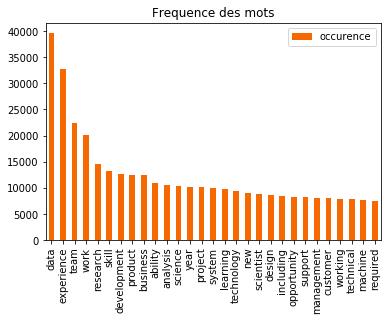

In [19]:
pd_dict_word.plot(kind='bar', color="#f56900", title='Frequence des mots');

Pour avoir une visualisation de nos données de façon assez concret, on va faire un wordclouding:

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt 
comment_words =""
for words in pd_dict_word.index: 
    comment_words = comment_words + words + ' '

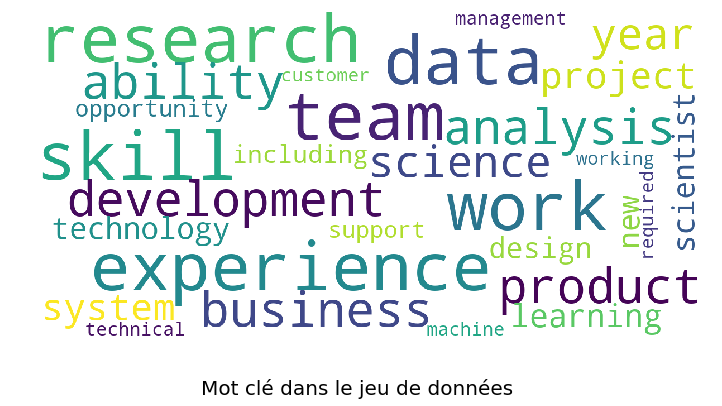

In [32]:
stopwords = set(STOPWORDS) 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(comment_words,title="Mot clé dans le jeu de données")

Comme on peut le voir, la plupart des mots qui se distinguent le plus sont des mots fréquents qu'on utilise pour les offres de travaille en générale. Pour avoir plus de recule sur les types d'offres, on va faire une filtre que sur les postes de data science pour voir ce que les recruteurs aux Etats Unis utilisent vraiment comme mots clés.Nous allons aussi enlever les mots qui ne montrent pas l'interêt du type d'offre data scientist.

In [33]:
mot_prohiber=["including","year","experience","development",
              "management","opportunity","ability","work",
              "business","ability","technical","team","skill","research"]

Commencons d'abord à visualiser les différentes profiles dans le domaine de la data que l'on peut avoir sur le marché:

###  Filtrage sur les métiers de data sciences:
Comme on ne dispose pas de labels dans nos données, on va construire notre filtre à partir des mots clés dans pour un poste de data scientist.

In [34]:
List1=data_read.position
filter_science=["scientist","science","forecasting","learning","forecaster","technical writter"]

In [35]:
def const_ind_lab(filter_name,List_name):
    List_res=[False for k in range(len(List_name))]
    for k in range(len(filter_name)):
        for i in range(len(List_name)):
                if filter_name[k] in np.str(List_name[i]).lower():
                    List_res[i]=True
    return List_res

In [36]:
Liste_science=const_ind_lab(filter_science,List1)
Post_data_science=data_read.iloc[Liste_science,:]

## Analyse des mots pour les postes de data science:

In [37]:
description=Post_data_science.description
pd_dict_word= word_count_text(description,N_min=1000,prohib_word=mot_prohiber)

## Visualisation de la fréquence des mots:

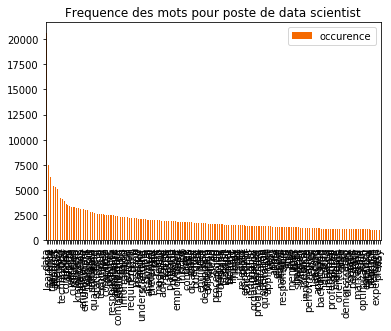

In [38]:
pd_dict_word.plot(kind='bar', color="#f56900", title='Frequence des mots pour poste de data scientist');

## Bag of words:

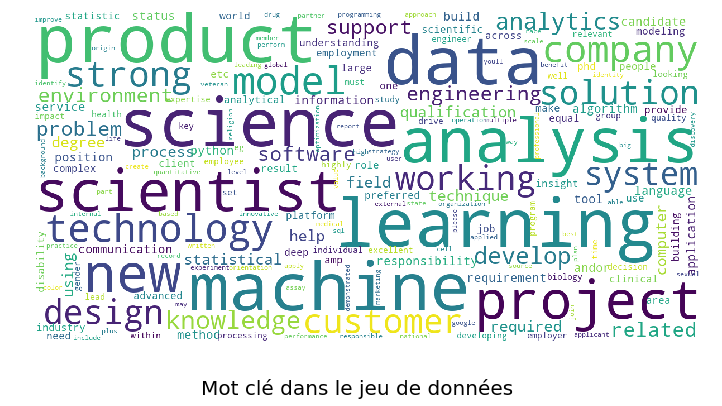

In [222]:
comment_words =""
for words in pd_dict_word.index: 
    comment_words = comment_words + words + ' '

show_wordcloud(comment_words,title="Mot clé dans le jeu de données")